# RBC with Tax (Coleman 1991)

Household: 
- $V(k,K,z) = \max_{c,k'} \{u(c)+βE[V(k',K',z')|z]\}$
- $u(c) = c^{(1-\sigma)}/(1-\sigma)$
- $c+k'=(1-\tau(K,z))(f(K,z)+(k-K)(f_1(K,z)+(1-\delta)k+d(K,z)=y(k,K,z)$
- $c,k' \in [0,y(k,K,z)]$
- $f(k,z) = zk^\alpha$
- $f_{1}(k,z) = z\alpha k^{\alpha-1}$
- $F(k,z) = zk^\alpha +(1-\delta)k$

Tax: 
- Tax Policy: $\tau(K,z)$ s.t. $(1-\tau(K,z))f_1(K,z)$ falling in $K$
- Transfer: $d(K,z) = \tau(K,z)$

Solution: 
- Find $k_{ss}$ from $1=\beta*(1-\tau(k_{ss},E[z])\alpha k_{ss}^{\alpha-1}+1-\delta)$ 
- Guess $c_{t}(k,z)$ in $[k_{ss}*0.9, k_{ss}*1.1]$x$Z$
- Define $H(k,z)=(1-\delta)+(1-\tau(k,z))f_{1}(k,z)$
- For each $k,z$, update $c_{t+1}(k,z)$ with $c$ that solves: $u'(c)-\beta E[u'(c_{t}(f(k,z)-c,z')) H(f(k,z)-c,z')|z]=0$ until convergence
- Store policy rules $c(k,z)$ and $k'(k,z) = f(k,z)+(1-\delta)k - c(k,z)$
- From initial $k_{0},z_{0}$ simulate economy with $k_{t+1}=k'(k_{t},z_{t})$ and $c_{t}=c(k_{t},z_{t})$

In [15]:
using LinearAlgebra, Statistics
using BenchmarkTools, Interpolations, LaTeXStrings, Parameters, Plots, QuantEcon, Roots
using Optim, Random
using BenchmarkTools, Interpolations, Parameters, Plots, QuantEcon, Roots
σ = 2.0;
β = 0.99;
α = 0.36;
δ = 0.025;
τ = 0.1;
Z = [0.99 1.01]
P = Array([0.9 0.1; 0.1 0.9])
up(c) = c^(-σ)
f(k,z) = z*k^α
F(k,z) = z*k^α+(1-δ)*k
fp(k,z) = z*α*k^(α-1)
H(k,z) = (1-τ)*fp(k,z)+(1-δ)
Kss = ((1/β+δ-1)/(α*(1-τ)))^(1/(α-1))
Css = Kss^α-δ*Kss
println((Kss,Css))
K = Array(range(Kss*0.8, Kss*1.2, 200))
    
function coleman!(Kg1, Kg2, g1, g2, K, β, up, f, fp)
    c1 = LinearInterpolation(K, g1, extrapolation_bc = Line()) # c(k,z1)
    c2 = LinearInterpolation(K, g2, extrapolation_bc = Line()) # c(k,z2)
    for (i,k) in enumerate(K)
        function h1(c) # Euler at k,z1
            kp = F(k,Z[1])-c 
            val1 = up.(c1.(kp)).* H(kp,Z[1]) #z'=z[1]
            val2 = up.(c2.(kp)).* H(kp,Z[2]) #z'=z[2]
            return up(c) - β*(P[1,1]*val1+P[1,2]*val2)
        end
        function h2(c) # Euler at k,z2
            kp = F(k,Z[2])-c 
            val1 = up.(c1.(kp)).* H(kp,Z[1]) #z'=z[1]
            val2 = up.(c2.(kp)).* H(kp,Z[2]) #z'=z[2]
            return up(c) - β*(P[2,1]*val1+P[2,2]*val2)
        end
        Kg1[i] = find_zero(h1, (1e-10, F(k,Z[1])-1e-10)) # Update c(k,z1)
        Kg2[i] = find_zero(h2, (1e-10, F(k,Z[2])-1e-10)) # Update c(k,z2)
    end
    return Kg1,Kg2
end
coleman(g1, g2, K, β, up, f, fp) = coleman!(similar(g1), similar(g2), g1, g2, K, β, up, f, fp)

function timeIteration(c1_init, c2_init)
    c1 = c1_init
    c2 = c2_init
    error=1
    while error>1e-6
        new_c1, new_c2 = coleman(c1, c2, K, β, up, f, fp)
        error = norm(c1-new_c1)+norm(c2-new_c2)
        c1 = new_c1
        c2 = new_c2        
    end
    return c1,c2
end
c1,c2 = timeIteration(1/13*K, 1/13*K)

(32.22290426894504, 2.6853424804002026)


([2.42374799927118, 2.4264826891997515, 2.4292140196405363, 2.431942003208619, 2.434666652423948, 2.4373879797113664, 2.4401059974004933, 2.4428207177255477, 2.4455321528252174, 2.448240314742277  …  2.894174669087627, 2.8964364572200147, 2.8986964001811955, 2.9009545030812487, 2.903210770993573, 2.9054652089558273, 2.9077178219707935, 2.9099686150073385, 2.912217593001235, 2.9144647608559233], [2.4319539447544356, 2.434688888437872, 2.437420468579191, 2.4401486977390383, 2.4428735883788315, 2.4455951528599864, 2.4483134034434557, 2.45102835229016, 2.4537400114591716, 2.456448392907499  …  2.902399069007677, 2.9046608890411934, 2.906920864739911, 2.9091790011549703, 2.9114353033025973, 2.9136897761652096, 2.9159424246924255, 2.918193253801985, 2.9204422683806097, 2.922689473284793])

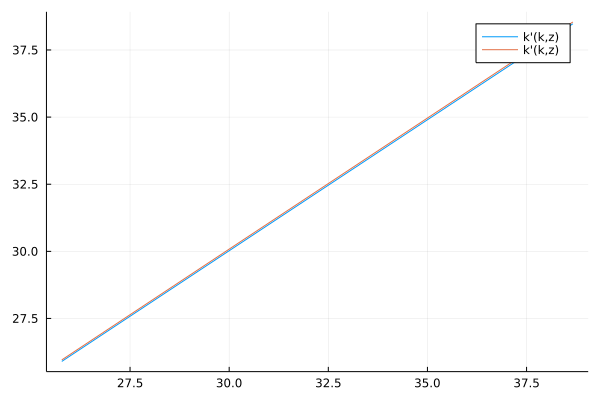

In [16]:
k1 = F.(K,Z[1]) - c1;
k2 = F.(K,Z[2]) - c2;
KP = hcat(k1,k2)
CP = hcat(c1,c2)
plot(K, KP, label="k'(k,z)")

In [17]:
KP

200×2 Matrix{Float64}:
 25.8994  25.9556
 25.9627  26.0189
 26.0259  26.0823
 26.0892  26.1456
 26.1525  26.209
 26.2158  26.2723
 26.2791  26.3357
 26.3424  26.399
 26.4057  26.4624
 26.469   26.5257
 26.5323  26.5891
 26.5956  26.6524
 26.6589  26.7158
  ⋮       
 37.7823  37.8482
 37.8455  37.9113
 37.9086  37.9745
 37.9717  38.0377
 38.0349  38.1009
 38.098   38.1641
 38.1611  38.2272
 38.2243  38.2904
 38.2874  38.3536
 38.3505  38.4168
 38.4137  38.4799
 38.4768  38.5431

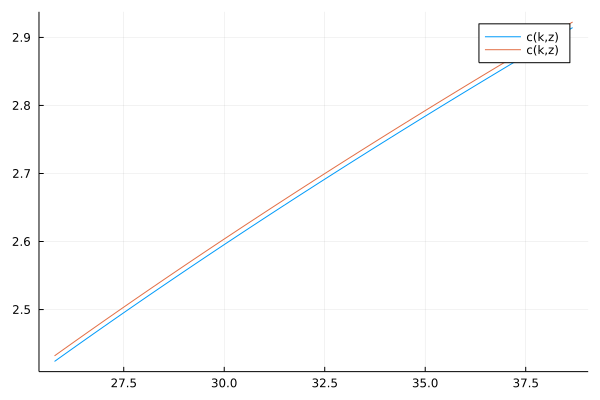

In [18]:
plot(K, CP, label="c(k,z)")

In [19]:
CP

200×2 Matrix{Float64}:
 2.42375  2.43195
 2.42648  2.43469
 2.42921  2.43742
 2.43194  2.44015
 2.43467  2.44287
 2.43739  2.4456
 2.44011  2.44831
 2.44282  2.45103
 2.44553  2.45374
 2.44824  2.45645
 2.45095  2.45915
 2.45365  2.46186
 2.45635  2.46455
 ⋮        
 2.88965  2.89787
 2.89191  2.90014
 2.89417  2.9024
 2.89644  2.90466
 2.8987   2.90692
 2.90095  2.90918
 2.90321  2.91144
 2.90547  2.91369
 2.90772  2.91594
 2.90997  2.91819
 2.91222  2.92044
 2.91446  2.92269

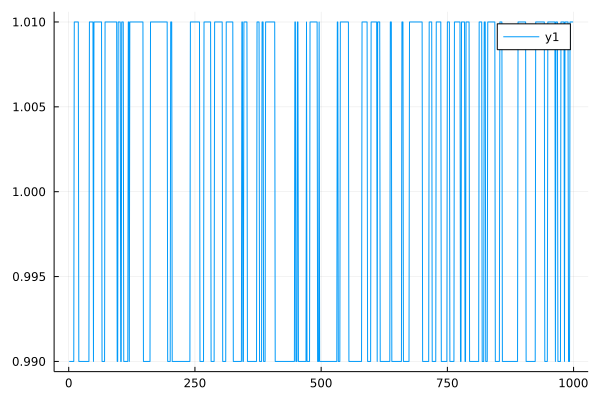

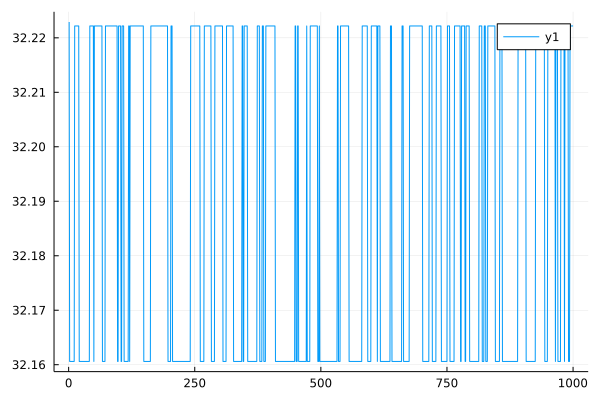

In [20]:
# Simulate
using QuantEcon
k0 = Kss
z0 = Z[1]
T = 1000
ZIND = simulate(MarkovChain(P), T);
KIND = simulate(MarkovChain(P), T);
KPATH = k0*Array(1:T)
ZPATH = z0*Array(1:T-1);
for i in 1:T-1
    z = ZIND[i]
    KIND[i] = partialsortperm(abs.(K .- KPATH[i]), 1)
    KPATH[i+1] = KP[KIND[i], z]
    ZPATH[i] = Z[z]
    #println((z, KIND[i], KPATH[i], KPATH[i+1], ZPATH[i]))
end
display(plot(ZPATH))
display(plot(KPATH))

In [21]:
model(Kss*0.9)

LoadError: UndefVarError: model not defined

In [22]:
K[1:50]

50-element Vector{Float64}:
 25.77832341515603
 25.843093071978032
 25.90786272880003
 25.97263238562203
 26.037402042444032
 26.10217169926603
 26.16694135608803
 26.231711012910033
 26.29648066973203
 26.361250326554032
 26.42601998337603
 26.49078964019803
 26.555559297020032
  ⋮
 28.239570374392034
 28.304340031214032
 28.369109688036033
 28.433879344858035
 28.498649001680032
 28.563418658502034
 28.628188315324035
 28.692957972146033
 28.757727628968034
 28.822497285790032
 28.887266942612033
 28.952036599434035

In [23]:
Kss*0.9

29.000613842050534

In [24]:
CP[50]

2.554009991847723